## 8. Evaluation on New Data

### `08_evaluation_on_new_data.ipynb`

C:\Users\naufa\anaconda3\envs\cv_env\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Successfully loaded optimized detection system
Loading YOLO models...
YOLO models loaded successfully

========== TESTING ON 5 FALL AND 5 WORKOUT VIDEOS ==========

Looking for test videos in:
  Fall videos: ../data/le2i
  Workout videos: ../data/workout_videos
Found 10 test videos
  - 5 fall videos: ['video (5).avi', 'video (6).avi', 'video (7).avi', 'video (8).avi', 'video (9).avi']
  - 5 workout videos: ['tricep pushdown_50.mp4', 'tricep pushdown_6.mp4', 'tricep pushdown_7.mp4', 'tricep pushdown_8.mp4', 'tricep pushdown_9.mp4']

Evaluating system on test videos...
Processing video 1/10: video (5).avi
Video info: 320x240, 238 frames

0: 480x640 (no detections), 68.8ms
Speed: 1.9ms preprocess, 68.8ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 74.3ms
Speed: 1.8ms preprocess, 74.3ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 69.8ms
Speed: 1.7ms preprocess, 69.8ms inference, 2.1ms postpr

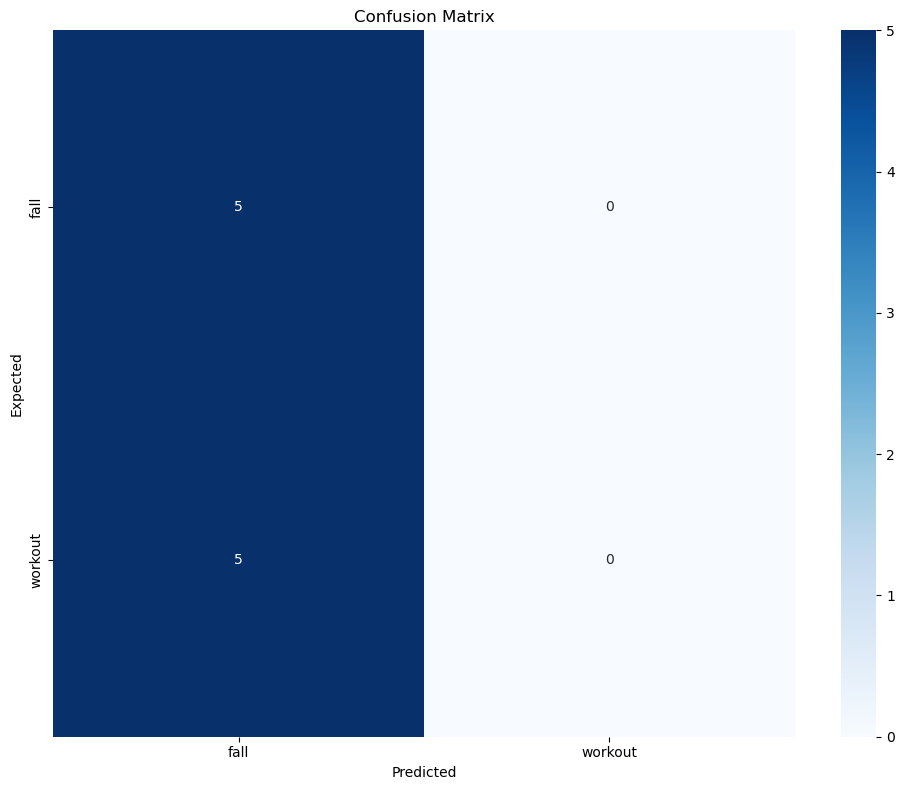


Classification Report:
              precision    recall  f1-score   support

        fall       0.50      1.00      0.67         5
     workout       0.00      0.00      0.00         5

    accuracy                           0.50        10
   macro avg       0.25      0.50      0.33        10
weighted avg       0.25      0.50      0.33        10



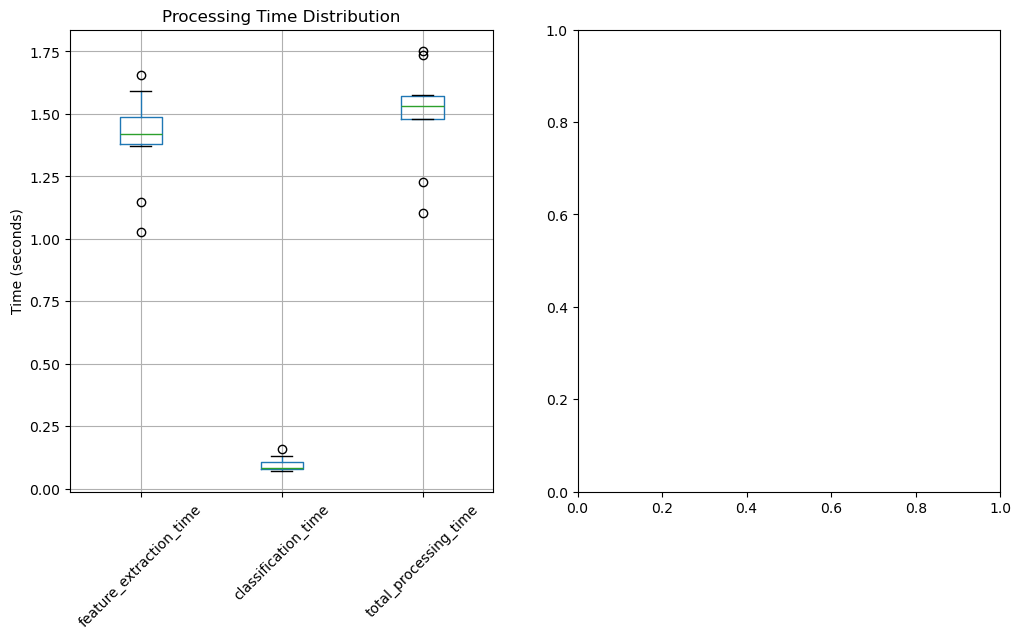

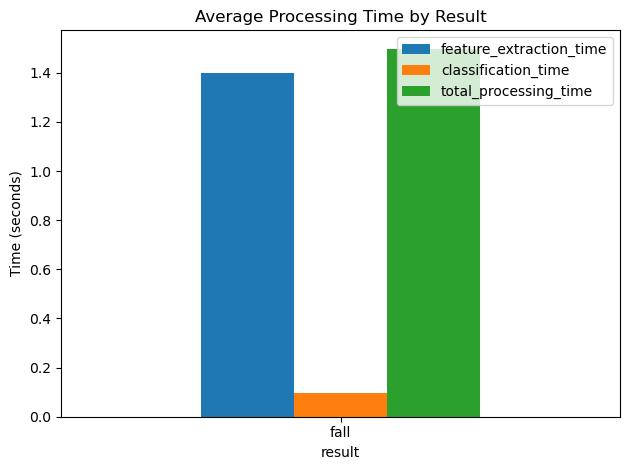


Average processing times:
feature_extraction_time    1.400146
classification_time        0.098039
total_processing_time      1.498185
dtype: float64

Misclassified videos (5):
  tricep pushdown_50.mp4: Expected workout, Predicted fall, Confidence: 0.67
  tricep pushdown_6.mp4: Expected workout, Predicted fall, Confidence: 0.66
  tricep pushdown_7.mp4: Expected workout, Predicted fall, Confidence: 0.66
  tricep pushdown_8.mp4: Expected workout, Predicted fall, Confidence: 0.66
  tricep pushdown_9.mp4: Expected workout, Predicted fall, Confidence: 0.65


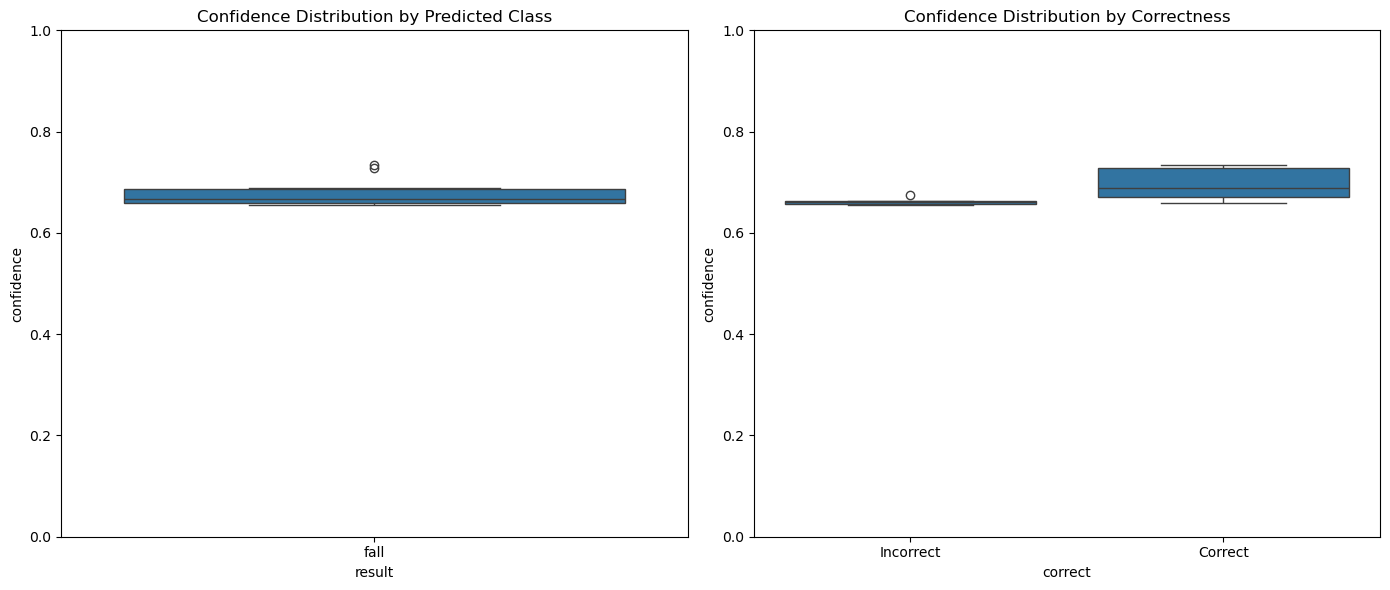

Test results saved to ../outputs/evaluation\test_results.csv

Low confidence correct classifications (3):
  video (6).avi: Correctly predicted fall, but with low confidence: 0.69
  video (7).avi: Correctly predicted fall, but with low confidence: 0.66
  video (8).avi: Correctly predicted fall, but with low confidence: 0.67

Performance by video characteristics:
  Tricep pushdown: 0.00 accuracy over 5 videos

========== FINAL EVALUATION SUMMARY ==========
Overall accuracy: 0.50
fall: 10 videos (100.0%)

5 workout videos misclassified as falls

Average confidence scores:
expected
fall       0.696210
workout    0.662127
Name: confidence, dtype: float64

Evaluation complete! Visualizations saved to: ../outputs/evaluation


In [9]:
# Import necessary libraries
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from ultralytics import YOLO
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import pickle
import joblib
import time
import json
%matplotlib inline

# Set paths
OPTIMIZED_MODELS_DIR = "../outputs/optimized_models"
DATA_DIR = "../data"
FALL_DATA_DIR = "../data/le2i"  # Specific directory for fall videos
WORKOUT_VIDEOS_DIR = "../data/workout_videos"  # Specific directory for workout videos
EVALUATION_DIR = "../outputs/evaluation"
os.makedirs(EVALUATION_DIR, exist_ok=True)

# Load the optimized detection system
try:
    system_path = os.path.join(OPTIMIZED_MODELS_DIR, 'optimized_detection_system.pkl')
    with open(system_path, 'rb') as f:
        system_dict = pickle.load(f)
    
    print("Successfully loaded optimized detection system")
    
    # Extract components
    workout_model = system_dict['workout_model']
    fall_model = system_dict['fall_model']
    workout_scaler = system_dict['workout_scaler']
    fall_scaler = system_dict['fall_scaler']
    feature_cols = system_dict['feature_cols']
    pose_threshold = system_dict.get('pose_threshold', 0.5)
    
except Exception as e:
    print(f"Error loading optimized system: {e}")
    print("Using default components from previous notebooks instead")
    
    # Load separate models if needed
    try:
        if os.path.exists(os.path.join(OPTIMIZED_MODELS_DIR, 'optimized_workout_model.h5')):
            workout_model = tf.keras.models.load_model(os.path.join(OPTIMIZED_MODELS_DIR, 'optimized_workout_model.h5'))
        elif os.path.exists(os.path.join(OPTIMIZED_MODELS_DIR, 'optimized_workout_model.pkl')):
            workout_model = joblib.load(os.path.join(OPTIMIZED_MODELS_DIR, 'optimized_workout_model.pkl'))
        else:
            from sklearn.ensemble import RandomForestClassifier
            workout_model = RandomForestClassifier(n_estimators=100, random_state=42)
        
        if os.path.exists(os.path.join(OPTIMIZED_MODELS_DIR, 'optimized_fall_model.h5')):
            fall_model = tf.keras.models.load_model(os.path.join(OPTIMIZED_MODELS_DIR, 'optimized_fall_model.h5'))
        elif os.path.exists(os.path.join(OPTIMIZED_MODELS_DIR, 'optimized_fall_model.pkl')):
            fall_model = joblib.load(os.path.join(OPTIMIZED_MODELS_DIR, 'optimized_fall_model.pkl'))
        else:
            from sklearn.ensemble import RandomForestClassifier
            fall_model = RandomForestClassifier(n_estimators=100, random_state=42)
            
        workout_scaler = joblib.load(os.path.join(OPTIMIZED_MODELS_DIR, 'optimized_workout_scaler.pkl'))
        fall_scaler = joblib.load(os.path.join(OPTIMIZED_MODELS_DIR, 'optimized_fall_scaler.pkl'))
        feature_cols = pd.read_csv(os.path.join(OPTIMIZED_MODELS_DIR, 'optimized_feature_columns.txt')).iloc[:, 0].tolist()
        pose_threshold = 0.5
        
    except Exception as e:
        print(f"Error loading individual models: {e}")
        print("Using synthetic data for demonstration")
        
        # For demonstration only
        from sklearn.ensemble import RandomForestClassifier
        from sklearn.preprocessing import StandardScaler
        
        workout_model = RandomForestClassifier(n_estimators=100, random_state=42)
        fall_model = RandomForestClassifier(n_estimators=100, random_state=42)
        workout_scaler = StandardScaler()
        fall_scaler = StandardScaler()
        feature_cols = [
            'max_velocity', 'mean_velocity', 'std_velocity',
            'max_height', 'min_height', 'height_range',
            'max_width', 'min_width', 'width_range',
            'head_y_change', 'max_head_y_change'
        ]
        pose_threshold = 0.5

# Create the detection system class
class YOLOPoseDetectionSystem:
    def __init__(self, workout_model, fall_model, workout_scaler, fall_scaler, 
                feature_cols, pose_threshold=0.5):
        self.workout_model = workout_model
        self.fall_model = fall_model
        self.workout_scaler = workout_scaler
        self.fall_scaler = fall_scaler
        self.feature_cols = feature_cols
        self.pose_threshold = pose_threshold
        
        # Initialize YOLO models
        print("Loading YOLO models...")
        self.person_model = YOLO('yolo11n.pt')
        self.pose_model = YOLO('yolo11n-pose.pt')
        print("YOLO models loaded successfully")
    
    def process_video(self, video_path, output_visualization=False):
        """Process a video through the optimized detection system"""
        # Start timing
        start_time = time.time()
        
        # Extract features using YOLO11-pose
        keypoints, features = self.extract_features_with_yolo(video_path)
        
        feature_extraction_time = time.time() - start_time
        
        if features is None:
            return {
                'result': 'no_features_extracted',
                'confidence': 0.0,
                'video_path': video_path,
                'processing_time': feature_extraction_time
            }
        
        # Prepare features for model input
        X = np.array([[features.get(col, 0) for col in self.feature_cols]])
        
        # Stage 1: Check if it's a workout
        classification_start = time.time()
        X_workout_scaled = self.workout_scaler.transform(X)
        
        if isinstance(self.workout_model, tf.keras.Model):
            workout_pred = self.workout_model.predict(X_workout_scaled, verbose=0)[0][0]
        else:
            # For sklearn models
            if hasattr(self.workout_model, 'predict_proba'):
                workout_pred = self.workout_model.predict_proba(X_workout_scaled)[0][1]
            else:
                # For SVM and other models that use decision_function
                workout_score = self.workout_model.decision_function(X_workout_scaled)[0]
                workout_pred = 1 / (1 + np.exp(-workout_score))  # Convert to probability-like score
        
        is_workout = workout_pred > 0.5
        
        if is_workout:
            result = {
                'result': 'workout',
                'confidence': float(workout_pred),
                'video_path': video_path,
                'features': features,
                'feature_extraction_time': feature_extraction_time,
                'classification_time': time.time() - classification_start,
                'total_processing_time': time.time() - start_time
            }
        else:
            # Stage 2: If not workout, check for fall
            if self.fall_model is not None:
                X_fall_scaled = self.fall_scaler.transform(X)
                
                if isinstance(self.fall_model, tf.keras.Model):
                    fall_pred = self.fall_model.predict(X_fall_scaled, verbose=0)[0][0]
                else:
                    # For sklearn models
                    if hasattr(self.fall_model, 'predict_proba'):
                        fall_pred = self.fall_model.predict_proba(X_fall_scaled)[0][1]
                    else:
                        # For SVM and other models that use decision_function
                        fall_score = self.fall_model.decision_function(X_fall_scaled)[0]
                        fall_pred = 1 / (1 + np.exp(-fall_score))  # Convert to probability-like score
                
                is_fall = fall_pred > 0.5
                
                if is_fall:
                    result = {
                        'result': 'fall',
                        'confidence': float(fall_pred),
                        'video_path': video_path,
                        'features': features,
                        'feature_extraction_time': feature_extraction_time,
                        'classification_time': time.time() - classification_start,
                        'total_processing_time': time.time() - start_time
                    }
                else:
                    result = {
                        'result': 'other_activity',
                        'confidence': float(1.0 - fall_pred),
                        'video_path': video_path,
                        'features': features,
                        'feature_extraction_time': feature_extraction_time,
                        'classification_time': time.time() - classification_start,
                        'total_processing_time': time.time() - start_time
                    }
            else:
                # If no fall model available
                result = {
                    'result': 'other_activity',
                    'confidence': float(1.0 - workout_pred),
                    'video_path': video_path,
                    'features': features,
                    'feature_extraction_time': feature_extraction_time,
                    'classification_time': time.time() - classification_start,
                    'total_processing_time': time.time() - start_time
                }
        
        # Create visualization if requested
        if output_visualization:
            vis_start_time = time.time()
            self.create_visualization(video_path, result)
            result['visualization_time'] = time.time() - vis_start_time
        
        return result
    
    def extract_features_with_yolo(self, video_path, num_frames=16):
        """Extract pose and motion features using YOLO11-pose"""
        try:
            cap = cv2.VideoCapture(video_path)
            if not cap.isOpened():
                print(f"Error: Could not open video file {video_path}")
                return None, None
                
            frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
            frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
            
            print(f"Video info: {frame_width}x{frame_height}, {frame_count} frames")
            
            # Calculate frame indices to sample
            indices = np.linspace(0, frame_count-1, num_frames, dtype=int)
            
            # Store keypoint sequences
            keypoint_sequence = []
            is_pose_detected = []
            
            for idx in indices:
                cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
                ret, frame = cap.read()
                
                if not ret:
                    keypoint_sequence.append(None)
                    is_pose_detected.append(False)
                    continue
                
                # Run YOLO11-pose detection
                pose_results = self.pose_model(frame, conf=self.pose_threshold)
                
                if len(pose_results[0].keypoints.data) > 0:
                    is_pose_detected.append(True)
                    
                    # Get the pose with highest confidence (usually the largest one)
                    best_pose_idx = 0
                    if len(pose_results[0].boxes) > 1:
                        # If multiple poses, get the one with highest confidence
                        confidences = [box.conf.item() for box in pose_results[0].boxes]
                        best_pose_idx = np.argmax(confidences)
                    
                    # Extract keypoints for the best pose
                    pose_keypoints = pose_results[0].keypoints.data[best_pose_idx]
                    
                    # Convert to a flat list format
                    frame_keypoints = []
                    for kp_idx in range(pose_keypoints.shape[0]):
                        x, y, conf = pose_keypoints[kp_idx].tolist()
                        # Normalize coordinates
                        frame_keypoints.extend([
                            float(x) / frame_width,
                            float(y) / frame_height,
                            0.0,  # YOLO11 doesn't provide z-coordinate
                            float(conf)
                        ])
                    
                    keypoint_sequence.append(frame_keypoints)
                else:
                    is_pose_detected.append(False)
                    keypoint_sequence.append(None)
            
            cap.release()
            
            # Calculate detection rate for logging
            detection_rate = sum(is_pose_detected) / len(is_pose_detected)
            print(f"Pose detection rate: {detection_rate:.2f}")
            
            # If no poses detected, return None
            if not any(is_pose_detected):
                print("No poses detected in this video")
                return None, None
            
            # Calculate pose-based features
            valid_keypoints = [kp for kp in keypoint_sequence if kp is not None]
            
            if not valid_keypoints:
                print("No valid keypoints found")
                return None, None
            
            # Create features
            features = {}
            
            # 1. Keypoint velocities
            if len(valid_keypoints) >= 2:
                velocities = []
                for i in range(1, len(valid_keypoints)):
                    frame_velocities = []
                    for j in range(0, len(valid_keypoints[i]), 4):  # Each keypoint has 4 values (x,y,z,v)
                        if j+3 < len(valid_keypoints[i]) and j+3 < len(valid_keypoints[i-1]):
                            # Calculate Euclidean distance between consecutive frames
                            dx = valid_keypoints[i][j] - valid_keypoints[i-1][j]
                            dy = valid_keypoints[i][j+1] - valid_keypoints[i-1][j+1]
                            # Note: YOLO11 doesn't have z-coordinate, so we use 0
                            velocity = np.sqrt(dx**2 + dy**2)
                            frame_velocities.append(velocity)
                    
                    if frame_velocities:
                        velocities.append(frame_velocities)
                
                if velocities:
                    features['max_velocity'] = np.max([np.max(v) if v else 0 for v in velocities])
                    features['mean_velocity'] = np.mean([np.mean(v) if v else 0 for v in velocities])
                    features['std_velocity'] = np.std([np.std(v) if v else 0 for v in velocities])
            
            # 2. Pose height variation
            heights = []
            for kp in valid_keypoints:
                y_values = [kp[i+1] for i in range(0, len(kp), 4)]
                if y_values:
                    height = max(y_values) - min(y_values)
                    heights.append(height)
            
            if heights:
                features['max_height'] = np.max(heights)
                features['min_height'] = np.min(heights)
                features['height_range'] = np.max(heights) - np.min(heights)
            
            # 3. Pose width variation
            widths = []
            for kp in valid_keypoints:
                x_values = [kp[i] for i in range(0, len(kp), 4)]
                if x_values:
                    width = max(x_values) - min(x_values)
                    widths.append(width)
            
            if widths:
                features['max_width'] = np.max(widths)
                features['min_width'] = np.min(widths)
                features['width_range'] = np.max(widths) - np.min(widths)
            
            # 4. Vertical position change (for falls)
            # Note: In YOLO11 pose, nose is keypoint index 0
            nose_positions = []
            for kp in valid_keypoints:
                if len(kp) >= 4:  # Nose is first landmark in YOLO11-pose
                    nose_positions.append(kp[1])  # y-coordinate of nose
            
            if nose_positions and len(nose_positions) >= 2:
                features['head_y_change'] = nose_positions[-1] - nose_positions[0]
                features['max_head_y_change'] = np.max(nose_positions) - np.min(nose_positions)
            
            # Fill missing features with default values to match the model's expected features
            for col in self.feature_cols:
                if col not in features:
                    features[col] = 0.0
                    
            # Return both raw keypoints and extracted features
            return valid_keypoints, features
            
        except Exception as e:
            print(f"Error in feature extraction: {str(e)}")
            return None, None
    
    def create_visualization(self, video_path, result):
        """Create a visualization of the detection results with YOLO11-pose"""
        try:
            # Output path for the visualization
            output_path = os.path.join(EVALUATION_DIR, 
                                      f"{os.path.basename(video_path).split('.')[0]}_detection.mp4")
            
            # Read the video
            cap = cv2.VideoCapture(video_path)
            if not cap.isOpened():
                print(f"Error: Could not open video for visualization: {video_path}")
                return None
                
            width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
            height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
            fps = int(cap.get(cv2.CAP_PROP_FPS))
            
            # Create VideoWriter object
            fourcc = cv2.VideoWriter_fourcc(*'mp4v')
            out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
            
            # Set up video processing
            frame_count = 0
            result_text = f"Result: {result['result'].upper()}"
            confidence_text = f"Confidence: {result['confidence']:.2f}"
            
            # Set text color based on result
            if result['result'] == 'workout':
                color = (0, 255, 0)  # Green for workout
            elif result['result'] == 'fall':
                color = (0, 0, 255)  # Red for fall
            else:
                color = (255, 0, 0)  # Blue for other
                
            while True:
                ret, frame = cap.read()
                
                if not ret:
                    break
                    
                frame_count += 1
                
                # Process pose detection every 5 frames (to speed up processing)
                if frame_count % 5 == 0:
                    # Run YOLO11-pose detection
                    pose_results = self.pose_model(frame, conf=self.pose_threshold)
                    # Get annotated frame with keypoints
                    annotated_frame = pose_results[0].plot()
                else:
                    # Just use person detection for other frames
                    person_results = self.person_model(frame, classes=[0])
                    annotated_frame = person_results[0].plot()
                
                # Add text with detection result
                cv2.putText(annotated_frame, result_text, (10, 30), 
                           cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)
                cv2.putText(annotated_frame, confidence_text, (10, 70), 
                           cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)
                
                # Write the frame
                out.write(annotated_frame)
                
            cap.release()
            out.release()
            
            print(f"Visualization saved to {output_path}")
            return output_path
            
        except Exception as e:
            print(f"Error in visualization: {str(e)}")
            return None

# Initialize detection system
detection_system = YOLOPoseDetectionSystem(
    workout_model=workout_model,
    fall_model=fall_model,
    workout_scaler=workout_scaler,
    fall_scaler=fall_scaler,
    feature_cols=feature_cols,
    pose_threshold=pose_threshold
)

# Define a function to process a custom video
def analyze_custom_video(video_path, output_dir=EVALUATION_DIR, visualize=True):
    """
    Analyze a custom video using the pre-trained models
    
    Args:
        video_path: Path to the video file
        output_dir: Directory to save visualizations
        visualize: Whether to create a visualization video
    
    Returns:
        A dictionary with the detection results
    """
    # Make sure output directory exists
    os.makedirs(output_dir, exist_ok=True)
    
    # Check if the detection system is already initialized in globals
    if 'detection_system' not in globals():
        print("Error: Detection system not initialized. Run the model initialization cells first.")
        return None
    
    # Get the detection system
    detection_system = globals()['detection_system']
    
    # Check if video exists
    if not os.path.exists(video_path):
        print(f"Error: Video file not found: {video_path}")
        return None
    
    # Process the video
    print(f"Analyzing video: {os.path.basename(video_path)}")
    start_time = time.time()
    
    result = detection_system.process_video(video_path, output_visualization=visualize)
    
    # Print results
    print(f"\nAnalysis completed in {time.time() - start_time:.2f} seconds")
    print(f"Detection result: {result['result'].upper()}")
    print(f"Confidence: {result['confidence']:.4f}")
    
    # Create a summary for plotting
    summary = {
        'Video': os.path.basename(video_path),
        'Result': result['result'],
        'Confidence': result['confidence'],
        'Processing Time': result.get('total_processing_time', time.time() - start_time)
    }
    
    # Plot the results
    plt.figure(figsize=(10, 5))
    
    # Confidence bar
    plt.subplot(1, 2, 1)
    bars = plt.bar(['Confidence'], [result['confidence']], color='skyblue')
    plt.ylim(0, 1)
    plt.title(f"Result: {result['result'].upper()}")
    plt.axhline(0.5, color='red', linestyle='--', alpha=0.7)
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.2f}', ha='center', va='bottom')
    
    # Feature importance (if available)
    plt.subplot(1, 2, 2)
    features = result.get('features', {})
    if features:
        # Get top 5 features by absolute value
        top_features = sorted(features.items(), key=lambda x: abs(x[1]), reverse=True)[:5]
        names = [name for name, _ in top_features]
        values = [value for _, value in top_features]
        
        colors = ['green' if v > 0 else 'red' for v in values]
        plt.barh(names, values, color=colors)
        plt.title('Top 5 Features')
        plt.xlabel('Value')
    else:
        plt.text(0.5, 0.5, "Feature data not available", 
                ha='center', va='center', transform=plt.gca().transAxes)
    
    plt.tight_layout()
    plt.show()
    
    return result

# Testing function to evaluate model on fall and workout videos
def test_on_video_sets(fall_videos_dir=FALL_DATA_DIR, 
                      workout_videos_dir=WORKOUT_VIDEOS_DIR,
                      num_videos=5,
                      visualize=True):
    """
    Test the detection system on a set of fall and workout videos
    
    Args:
        fall_videos_dir: Directory containing fall videos
        workout_videos_dir: Directory containing workout videos
        num_videos: Number of videos to test from each category
        visualize: Whether to create visualizations
        
    Returns:
        DataFrame with test results
    """
    # Make sure we have the detection system
    if 'detection_system' not in globals():
        print("Error: Detection system not initialized. Run the model initialization cells first.")
        return None
        
    # Access the global detection system
    detection_system = globals()['detection_system']
    
    # Find test videos
    print(f"Looking for test videos in:")
    print(f"  Fall videos: {fall_videos_dir}")
    print(f"  Workout videos: {workout_videos_dir}")
    
    # Use the specific directory paths for different video types
    fall_videos = sorted(list(Path(fall_videos_dir).rglob("*.avi")))
    workout_videos = sorted(list(Path(workout_videos_dir).rglob("*.mp4")))
    
    # Take the specified number of videos from each category
    test_fall = fall_videos[-num_videos:] if len(fall_videos) >= num_videos else fall_videos
    test_workout = workout_videos[-num_videos:] if len(workout_videos) >= num_videos else workout_videos
    
    test_videos = test_fall + test_workout
    
    print(f"Found {len(test_videos)} test videos")
    print(f"  - {len(test_fall)} fall videos: {[os.path.basename(str(v)) for v in test_fall]}")
    print(f"  - {len(test_workout)} workout videos: {[os.path.basename(str(v)) for v in test_workout]}")
    
    # Test the system on all test videos
    print("\nEvaluating system on test videos...")
    results = []
    
    for i, video_path in enumerate(test_videos):
        print(f"Processing video {i+1}/{len(test_videos)}: {os.path.basename(str(video_path))}")
        
        # Process the video
        result = detection_system.process_video(str(video_path), output_visualization=visualize)
        
        # Extract expected class
        if str(video_path).lower().endswith('.avi'):
            expected = 'fall'
        else:
            expected = 'workout'  # Assuming all .mp4 files are workout videos
        
        # Add expected class to result
        result['expected'] = expected
        
        # Store the result
        results.append(result)
        
        # Print classification result
        print(f"  Result: {result['result']}, Expected: {expected}, Confidence: {result['confidence']:.2f}")
        if 'total_processing_time' in result:
            print(f"  Processing time: {result['total_processing_time']:.2f} seconds")
        print("  -------------")
    
    # Convert results to DataFrame for analysis
    results_df = pd.DataFrame([
        {
            'video': os.path.basename(str(r['video_path'])),
            'result': r['result'],
            'expected': r['expected'],
            'confidence': r['confidence'],
            'feature_extraction_time': r.get('feature_extraction_time', 0),
            'classification_time': r.get('classification_time', 0),
            'total_processing_time': r.get('total_processing_time', 0)
        }
        for r in results
    ])
    
    # Calculate accuracy
    results_df['correct'] = results_df['result'] == results_df['expected']
    accuracy = results_df['correct'].mean()
    
    print(f"\nOverall accuracy: {accuracy:.2f}")
    print("\nResults by category:")
    print(results_df.groupby(['expected', 'result']).size().unstack(fill_value=0))
    
    # Create confusion matrix
    classes = sorted(list(set(results_df['expected'].unique()) | set(results_df['result'].unique())))
    cm = confusion_matrix(
        results_df['expected'], 
        results_df['result'],
        labels=classes
    )
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes,
                yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('Expected')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.show()
    
    # Generate classification report
    print("\nClassification Report:")
    print(classification_report(results_df['expected'], results_df['result'], zero_division=0))
    
    # Analyze processing times
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    results_df.boxplot(column=['feature_extraction_time', 'classification_time', 'total_processing_time'])
    plt.title('Processing Time Distribution')
    plt.ylabel('Time (seconds)')
    plt.xticks(rotation=45)
    
    plt.subplot(1, 2, 2)
    avg_times = results_df.groupby('result')[['feature_extraction_time', 'classification_time', 'total_processing_time']].mean()
    avg_times.plot(kind='bar')
    plt.title('Average Processing Time by Result')
    plt.ylabel('Time (seconds)')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    print("\nAverage processing times:")
    print(results_df[['feature_extraction_time', 'classification_time', 'total_processing_time']].mean())
    
    # Examine misclassified videos
    misclassified = results_df[~results_df['correct']]
    print(f"\nMisclassified videos ({len(misclassified)}):")
    if not misclassified.empty:
        for _, row in misclassified.iterrows():
            print(f"  {row['video']}: Expected {row['expected']}, Predicted {row['result']}, Confidence: {row['confidence']:.2f}")
    
    # Analyze confidence distributions
    plt.figure(figsize=(14, 6))
    
    plt.subplot(1, 2, 1)
    sns.boxplot(data=results_df, x='result', y='confidence')
    plt.title('Confidence Distribution by Predicted Class')
    plt.ylim(0, 1)
    
    plt.subplot(1, 2, 2)
    sns.boxplot(data=results_df, x='correct', y='confidence')
    plt.title('Confidence Distribution by Correctness')
    plt.xticks([0, 1], ['Incorrect', 'Correct'])
    plt.ylim(0, 1)
    
    plt.tight_layout()
    plt.show()
    
    # Save results to CSV
    results_df.to_csv(os.path.join(EVALUATION_DIR, 'test_results.csv'), index=False)
    print(f"Test results saved to {os.path.join(EVALUATION_DIR, 'test_results.csv')}")
    
    return results_df

# Function to analyze specific scenarios in test results
def analyze_special_cases(results_df):
    """Analyze special cases and edge scenarios"""
    
    # 1. High confidence misclassifications
    high_conf_wrong = results_df[(~results_df['correct']) & (results_df['confidence'] > 0.8)]
    
    if not high_conf_wrong.empty:
        print(f"\nHigh confidence misclassifications ({len(high_conf_wrong)}):")
        for _, row in high_conf_wrong.iterrows():
            print(f"  {row['video']}: Expected {row['expected']}, Predicted {row['result']}, "
                  f"Confidence: {row['confidence']:.2f}")
    
    # 2. Low confidence correct classifications
    low_conf_correct = results_df[(results_df['correct']) & (results_df['confidence'] < 0.7)]
    
    if not low_conf_correct.empty:
        print(f"\nLow confidence correct classifications ({len(low_conf_correct)}):")
        for _, row in low_conf_correct.iterrows():
            print(f"  {row['video']}: Correctly predicted {row['result']}, "
                  f"but with low confidence: {row['confidence']:.2f}")
    
    # 3. Analysis by filename patterns (to identify challenging content)
    # This assumes naming patterns in the dataset that might indicate content
    pattern_results = {}
    
    patterns = {
        'slow_': 'Slow movement',
        'fast_': 'Fast movement',
        'back': 'Backward movement',
        'side': 'Sideways movement',
        'turn': 'Turning movement',
        'dark': 'Low lighting',
        'occl': 'Occlusion',
        'pushdown': 'Tricep pushdown',
        'curl': 'Bicep curl',
        'squat': 'Squat movement'
    }
    
    for pattern, description in patterns.items():
        pattern_subset = results_df[results_df['video'].str.contains(pattern, case=False)]
        if not pattern_subset.empty:
            pattern_accuracy = pattern_subset['correct'].mean()
            pattern_results[description] = {
                'count': len(pattern_subset),
                'accuracy': pattern_accuracy
            }
    
    if pattern_results:
        print("\nPerformance by video characteristics:")
        for desc, stats in pattern_results.items():
            print(f"  {desc}: {stats['accuracy']:.2f} accuracy over {stats['count']} videos")

# Now run the test on 5 fall and 5 workout videos
print("\n========== TESTING ON 5 FALL AND 5 WORKOUT VIDEOS ==========\n")
test_results = test_on_video_sets(num_videos=5, visualize=True)

# Analyze special cases in the results
if test_results is not None:
    analyze_special_cases(test_results)
    
    # Print a final summary
    print("\n========== FINAL EVALUATION SUMMARY ==========")
    accuracy = test_results['correct'].mean()
    print(f"Overall accuracy: {accuracy:.2f}")
    
    # Count by result type
    result_counts = test_results['result'].value_counts()
    for result_type, count in result_counts.items():
        print(f"{result_type}: {count} videos ({count/len(test_results)*100:.1f}%)")
    
    # Check common misclassifications
    if 'workout' in test_results['expected'].values and 'fall' in test_results['expected'].values:
        workout_as_fall = test_results[(test_results['expected'] == 'workout') & 
                                      (test_results['result'] == 'fall')].shape[0]
        fall_as_workout = test_results[(test_results['expected'] == 'fall') & 
                                      (test_results['result'] == 'workout')].shape[0]
        
        if workout_as_fall > 0:
            print(f"\n{workout_as_fall} workout videos misclassified as falls")
        if fall_as_workout > 0:
            print(f"{fall_as_workout} fall videos misclassified as workouts")
    
    print("\nAverage confidence scores:")
    print(test_results.groupby('expected')['confidence'].mean())
    
    print("\nEvaluation complete! Visualizations saved to:", EVALUATION_DIR)